Мы будем предсказывать расположение и класс дефектов, обнаруженных на производстве стальных листов. Изображения имеют уникальные названия ImageId. Целью является сегментировать и классифицировать дефекты по изображениям из test датасета.<br>
Каждое изображение может вообще не иметь дефектов, иметь дефект только одного класса или дефекты нескольких классов. Для каждого изображения нужно сегментировать дефекты каждого класса (ClassId = [1, 2, 3, 4])<br>
Сегмент для дефекта каждого класса должен быть записан в отдельную строку, даже если на изображении присутствуют несколько дискретных расположений дефекта


**Файлы** <br>
- train_images/ - папка изображений для тренировки модели <br>
- test_images/ - папка изображений для тестирования модели (мы сегментируем и классифицируем эти изображения)<br>
- train.csv - аннотации с сегментами дефектов на изображениях из тренировочного датасета (ClassId = [1, 2, 3, 4])<br>
- sample_submission.csv - a sample submission file in the correct format; <br>


*note, each ImageId 4 rows, one for each of the 4 defect classes*

Пиксели номируются сверху вниз, потом слева направо, то есть 1й пиксель это $(0,0)$, 2й пиксель это $(1,0)$.<br>
То есть если на картинке пиксель $(i,j)$, где $i$ - номер строки, $j$ - номер столбца, то его номер $n$ вычисляется по формуле $n = 256* j + i + 1$<br>
Формула для вычисления i, j по порядковому номеру n:<br>
$j = int(n/256)$<br>
$i = n - 256*int(n/256) - 1 = n - 256*j -1$

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#%pip install opencv-python
#%pip install plotly
#%pip install -U protobuf==3.11.3
#%pip install seaborn
#%pip install imageio

In [3]:
#%pip install tensorflow h5py


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import seaborn as sns
#import pandas_profiling as pp
import os
from collections import defaultdict
import imageio
from PIL import Image
import cv2
import plotly
from plotly import graph_objects as go
import plotly.express as px
from keras.utils import Sequence
from skimage.io import imread
from sklearn.utils import shuffle
import tensorflow as tf
import albumentations as aug
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            GaussNoise,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)
from albumentations import Resize

2023-04-24 14:34:36.023878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
print(os.listdir("data"))

['test_images', 'train.csv', 'train_images', 'sample_submission.csv']


In [6]:
data_dir ="data"
input_file0 = "train.csv"
input_file1 = "sample_submission.csv"
abspath='/'.join(os.getcwd().split('\\')) 
source_folder = os.path.join(abspath, 'data')
df_train = pd.read_csv(os.path.join(source_folder,input_file0))
df_sample = pd.read_csv(os.path.join(source_folder,input_file1))

In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [8]:
df_train.shape

(7095, 3)

In [9]:
# Пути на папки с train_images и test_images соответственно
trainImgPath =os.path.join(source_folder,'train_images/')
testImgPath = os.path.join(source_folder,'test_images/')

In [10]:
# Создадим таблицу с ImageId из папки train_images
# Каждому ImageId будут соответствовать 4 строки (для каждого класса дефекта)
train_Img_Id = []
train_class_Id = []
for i in os.listdir(trainImgPath):
    for j in range(1,5):
        train_Img_Id.append(i)
        train_class_Id.append(j)
train_Imgs = pd.DataFrame(train_Img_Id,columns=['ImageId'])
train_Imgs['ClassId'] = train_class_Id

In [11]:
# Создадим таблицу - объединение 2х таблиц train_Img, df_train
# Nan значения заменим пустыми строками
train_d = pd.merge(train_Imgs, df_train,how='left', on=['ImageId','ClassId']) 
train_d = train_d.fillna('') 

In [12]:
train_d.shape

(50272, 3)

In [13]:
# Изменим структуру таблицы:
# каждому ImageId отвечает одна строка, а столбцы - это дефекты различных классов, если дефект какого-либо класса отсутствует, 
# то в соответствующем столбце - пустое значение
train_data = pd.pivot_table(train_d, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
train_data = train_data.reset_index() # add Index column to one level with classID   
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data.columns
train_data = train_data.replace({'nan':''})

In [14]:
print(train_data.shape)
print(len(np.unique(train_data.ImageId.values)))

(12568, 5)
12568


In [15]:
train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [16]:
# Добавим колонки: 
# has_defect - индификатор наличия дефекта какого-либо класса, 
has_defect = []
for index,row in train_data.iterrows():
    if row.Defect_1 or row.Defect_2 or row.Defect_3 or row.Defect_4: 
        has_defect.append(1)
    else:
        has_defect.append(0)
        
train_data["has_defect"] = has_defect 
number_of_defects=[]
for index, row in train_data.iterrows():
    i=0
    if row.Defect_1:
        i=i+1
    if row.Defect_2:
        i=i+1
    if row.Defect_3:
        i=i+1
    if row.Defect_4:
        i=i+1
    number_of_defects.append(i)
        
train_data["number_of_defects"] = number_of_defects  
train_data.head(5)

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,has_defect,number_of_defects
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1
1,00031f466.jpg,,,,,0,0
2,000418bfc.jpg,,,,,0,0
3,000789191.jpg,,,,,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,1


In [17]:
f='000418bfc.jpg'
data_path = os.path.join(source_folder,'train_images/')
orig_img=cv2.imread(os.path.join(data_path, f),cv2.IMREAD_COLOR)
o_i=cv2.resize(orig_img,(800,128))
print(orig_img.shape)
o_im=orig_img.copy()
new_img = cv2.resize(o_im,(800,128))
print(new_img.shape)

(256, 1600, 3)
(128, 800, 3)


In [18]:
import tensorflow.keras as keras

In [19]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, preprocess=None, info={},augmentation=False, transform=None):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.augmentation=augmentation
        self.transform=transform
        
        if self.subset == "train":
            self.data_path = os.path.join(source_folder,'train_images/')
        elif self.subset == "test":
            self.data_path = os.path.join(source_folder,'test_images/')
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,256,1600,3),dtype=np.float32)
        y = np.empty((self.batch_size,256,1600,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(os.path.join(self.data_path, f)).resize((1600,256))
            #X[i,] = np.asarray(X[i,], dtype=np.float32)/255
            X[i,] = np.asarray(X[i,], dtype=np.float32)
            #X[i,]=cv2.imread(os.path.join(self.data_path, f).format(img),cv2.IMREAD_COLOR)
            #X[i,]=cv2.resize(X[i,],(120,120))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle_to_mask(self.df['Defect_'+str(j+1)].iloc[indexes[i]])
                if self.augmentation==True:
                    masks = [y[i,:,:,k] for k in range(4)]
                    img = np.array(X[i,])
                    transformed = self.transform(image=img.astype('uint8'), masks=masks)
                    tr_img = transformed['image']
                    X[i,] = cv2.resize(tr_img,(1600,256))
                    tr_masks=transformed['masks']
                    for j1 in range(4):
                        y[i,:,:,j1] = tr_masks[j1] 
            
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

In [20]:
class DataGenerator1(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, preprocess=None, info={},augmentation=False, transform=None):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.augmentation=augmentation
        self.transform=transform
        
        if self.subset == "train":
            self.data_path = os.path.join(source_folder,'train_images/')
        elif self.subset == "test":
            self.data_path = os.path.join(source_folder,'test_images/')
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        Xt = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        yt = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(os.path.join(self.data_path, f)).resize((800,128))
            X[i,] = np.asarray(X[i,], dtype=np.float32)/255
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['Defect_'+str(j+1)].iloc[indexes[i]])
                if self.augmentation==True:
                    masks = [y[i,:,:,k] for k in range(4)]
                    img = np.array(X[i,])
                    transformed = self.transform(image=img.astype('uint8'), masks=masks)
                    tr_img = transformed['image']
                    Xt[i,] = cv2.resize(tr_img,(800,128))
                    tr_masks=transformed['masks']
                    for j1 in range(4):
                        yt[i,:,:,j1] = tr_masks[j1]
        if self.augmentation==True:    
            X = np.concatenate((X,Xt),axis=0)   
            y = np.concatenate((y,yt),axis=0)  
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

In [21]:
transform1 = aug.Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        #RandomGamma(p=0.25),
        #IAAEmboss(p=0.25),
        #Blur(p=0.01, blur_limit = 3),
        #OneOf([
            #ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            #GridDistortion(p=0.5),
            #OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        #], p=0.3)
    ], p = 0.8)

In [22]:
def mask_to_rle(mask):
    """
    params:  mask - numpy array
    returns: run-length encoding string (pairs of start & length of encoding)
    """
    
    # turn a n-dimensional array into a 1-dimensional series of pixels
    # for example:
    #     [[1. 1. 0.]
    #      [0. 0. 0.]   --> [1. 1. 0. 0. 0. 0. 1. 0. 0.]
    #      [1. 0. 0.]]
    flat = mask.flatten()
    
    # we find consecutive sequences by overlaying the mask
    # on a version of itself that is displaced by 1 pixel
    # for that, we add some padding before slicing
    padded = np.concatenate([[0], flat, [0]])
    
    # this returns the indices where the sliced arrays differ
    runs = np.where(padded[1:] != padded[:-1])[0] 
    # indexes start at 0, pixel numbers start at 1
    runs += 1

    # every uneven element represents the start of a new sequence
    # every even element is where the run comes to a stop
    # subtract the former from the latter to get the length of the run
    runs[1::2] -= runs[0::2]
 
    # convert the array to a string
    return ' '.join(str(x) for x in runs)

In [23]:
import tensorflow.keras as keras

In [24]:
path=source_folder+'/'

In [25]:
def rle_to_mask(lre, shape=(1600, 256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    h, w = shape
    if len(lre)>0:# the incoming string is space-delimited
        runs = np.asarray([int(run) for run in lre.split(' ')])

        # we do the same operation with the even and uneven elements, but this time with addition
        runs[1::2] += runs[0::2]
        # pixel numbers start at 1, indexes start at 0
        runs -= 1

        # extract the starting and ending indeces at even and uneven intervals, respectively
        run_starts, run_ends = runs[0::2], runs[1::2]

        # build the mask
        mask = np.zeros(h*w, dtype=np.uint8)
        for start, end in zip(run_starts, run_ends):
            mask[start:end] = 1
    elif len(lre)==0:
        mask = np.zeros(h*w, dtype=np.uint8)
    # transform the numpy array from flat to the original image shape
    return mask.reshape(shape).T

In [26]:
def load_img(img_id):
    img_dir='train_images' 
    img = cv2.imread(os.path.join(os.path.join(data_dir,img_dir), img_id))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

In [27]:
def show_masked_image(img_id, ax=None, thickness=2):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    img = load_img(img_id)
    for i, col in df_train[df_train['ImageId'] == img_id].iterrows():
        encoded_pixels = col['EncodedPixels']
        label = col['ClassId']
        mask = rle_to_mask(encoded_pixels, shape=(1600, 256))
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        img = cv2.drawContours(img, contours, -1, rgb_for_label[label], thickness=thickness)
    ax.imshow(img)
    return ax

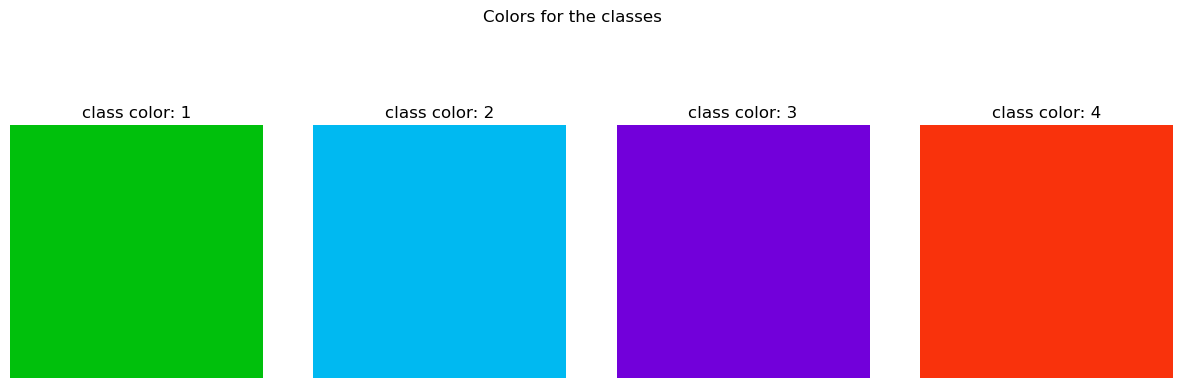

In [28]:
rgb_for_label = {i:v for i, v in enumerate([(0, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)], start=1)}

    
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(0, 4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * rgb_for_label[i+1])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("Colors for the classes")

plt.show()

In [29]:
#%pip install segmentation_models

In [30]:
%env SM_FRAMEWORK=tf.keras
from segmentation_models import Unet

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


## Modelling main

### Without augmentation


Possible backbones: ResNet: 'resnet18' 'resnet34' 'resnet50' 'resnet101' 'resnet152'


In [ ]:
#!g1.4
# Load U-Net pretrained from ImageNet
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    """
    Compute Dice Coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

BACKBONE = 'resnet101'

model = Unet(BACKBONE, input_shape=(256, 1600, 3), classes=4, activation='sigmoid', encoder_weights='imagenet')

opt = keras.optimizers.Adam(learning_rate=0.003)
lr_metric = get_lr_metric(opt)
model.compile(optimizer=opt , loss='binary_crossentropy', metrics=[dice_coef,  iou_coef, lr_metric])

EPOCHES=50 #100

# Train and validate the model
idx = int(0.8*len(train_data)); print()
train_batches = DataGenerator(train_data.iloc[:idx],shuffle=True)
valid_batches = DataGenerator(train_data.iloc[idx:])


from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', 
                             save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.33,
                                   patience=10, verbose=1, mode='max', cooldown=0, min_lr=0.00005)

early = EarlyStopping(monitor="dice_coef", mode="max", verbose=2,
                      patience=30) # probably needs to be more patient, but kaggle time is limited

#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   # filepath=checkpoint_filepath,
   # save_weights_only=True,
    #monitor='val_accuracy',
    #mode='max',
    #save_best_only=True)

callbacks_list = [checkpoint, early, reduceLROnPlat]
with tf.device('/GPU'):
    history = model.fit(train_batches, validation_data = valid_batches, epochs = EPOCHES, verbose=1,
                              callbacks=callbacks_list)
# SAVE MODEL

model.load_weights(weight_path)
model.save('UNET50no_aug_main.h5')

# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)
# Plot training
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()

2023-04-24 14:35:06.434138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/50
  4/629 [..............................] - ETA: 41:42:42 - loss: 0.5148 - dice_coef: 0.0233 - iou_coef: 0.0117 - lr: 0.0030

### With augmentation


In [ ]:
#!g1.1
# Load U-Net pretrained from ImageNet
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    """
    Compute Dice Coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

BACKBONE = 'resnet101'

model = Unet(BACKBONE, input_shape=(128, 800, 3), classes=4, activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
EPOCHES=150

# Train and validate the model
idx = int(0.8*len(train_data)); print()
train_batches = DataGenerator(train_data.iloc[:idx],shuffle=True, augmantation=True, transform=transform2)
valid_batches = DataGenerator(train_data.iloc[idx:])


from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', 
                             save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.33,
                                   patience=10, verbose=1, mode='max', cooldown=0, min_lr=0.001)

early = EarlyStopping(monitor="dice_coef", mode="max", verbose=2,
                      patience=30) # probably needs to be more patient, but kaggle time is limited

#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   # filepath=checkpoint_filepath,
   # save_weights_only=True,
    #monitor='val_accuracy',
    #mode='max',
    #save_best_only=True)

callbacks_list = [checkpoint, early, reduceLROnPlat]
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = EPOCHES, verbose=2, callbacks=callbacks_list)
# SAVE MODEL

model.load_weights(weight_path)
model.save('UNET50no_aug1.h5')

# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)
# Plot training
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()

## Training on augmented data

We load our previously pretrained model and train it on augmented images


In [ ]:
#!g1.1
from tensorflow.keras.models import load_model
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    """
    Compute Dice Coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

model1 = load_model('UNET50no_aug.h5',custom_objects={'dice_coef':dice_coef})
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
# Train and validate the model
idx = int(0.8*len(train_data)); print()
train_batches1 = DataGenerator(train_data.iloc[:idx],shuffle=True,augmentation=True, transform=transform1)
valid_batches1 = DataGenerator(train_data.iloc[idx:])

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max', 
                             save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.33,
                                   patience=10, verbose=1, mode='max', cooldown=0, min_lr=0.001)

early = EarlyStopping(monitor="dice_coef", mode="max", verbose=2,
                      patience=30) # probably needs to be more patient, but kaggle time is limited

#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   # filepath=checkpoint_filepath,
   # save_weights_only=True,
    #monitor='val_accuracy',
    #mode='max',
    #save_best_only=True)

callbacks_list = [checkpoint, early, reduceLROnPlat]
history1 = model1.fit_generator(train_batches1, validation_data = valid_batches1, epochs = 80, verbose=2, callbacks=callbacks_list)
# SAVE MODEL
model1.load_weights(weight_path)
model1.save('UNET50with_aug.h5')
# Plot training
plt.figure(figsize=(15,5))
plt.plot(range(history1.epoch[-1]+1),history1.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history1.epoch[-1]+1),history1.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()

In [ ]:
#!g1.1
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)
Compiling the model

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])
#Fitting the model

history = model.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1, callbacks=[early_stopping])


In [ ]:
#!g1.1
transform2 = aug.Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.06, rotate_limit=0, p=0.3),
        RandomGamma(p=0.25),
        #RandomContrast(p=0.5, limit=0.03),
        #GaussNoise(var_limit=(10,50), p=0.4),
        #RandomBrightness(limit=1,p=1),
        #IAAEmboss(p=0.25),
        Blur(p=0.5, blur_limit = 3),
        #OneOf([
            #ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            #GridDistortion(p=0.5),
            #OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        #], p=0.3)
    ], p = 1)

In [ ]:
#!g1.1
aug_medium=aug.Compose([
     aug.Flip(),
     aug.OneOf([
            aug.CLAHE(clip_limit=2, p=.5),
            aug.IAASharpen(p=.25),
            ], p=0.35),
     aug.OneOf([
         aug.RandomContrast(),
         aug.RandomGamma(),
         aug.RandomBrightness(),
         ], p=0.3),
     aug.OneOf([
         aug.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
         aug.GridDistortion(),
         aug.OpticalDistortion(distort_limit=2, shift_limit=0.5),
         ], p=0.3),
     aug.ShiftScaleRotate(rotate_limit=12),
     aug.OneOf([
            aug.GaussNoise(p=.35),
            #aug.SaltPepperNoise(level_limit=0.0002, p=.7),
            aug.ISONoise(p=.7),
            ], p=.5),
     aug.Cutout(num_holes=3, p=.25),
 ], p=1)

In [ ]:
#!g1.1
aug_medium1=aug.Compose([
     aug.Flip(),
     aug.OneOf([
         aug.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
         aug.GridDistortion(),
         aug.OpticalDistortion(distort_limit=2, shift_limit=0.5),
         ], p=0.3),
     aug.ShiftScaleRotate(rotate_limit=12, p=0.3),
    HorizontalFlip(p=0.4),
    VerticalFlip(p=0.4),
    Blur(p=0.5, blur_limit = 3)
 ], p=1)

In [ ]:
def show_mask_image(img, mask, label, ax=None, thickness=2):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
        
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    img = cv2.drawContours(img, contours, -1, rgb_for_label[label], thickness=thickness)
    ax.imshow(img)
    return ax

In [ ]:
#!c1.8
ex_gen = DataGenerator(train_data.iloc[:16],shuffle=False,augmentation=True, transform=aug_medium)
#val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)
 
 
# Display input image
from PIL import Image
def visualize(image):
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    #plt.imshow(image)
    plt.imshow(image.astype('uint8'))
    
for i, j in ex_gen:
    for k in range(5):
        filepath=os.path.join(os.path.join(source_folder,'train_images/'), train_data.ImageId[k])
        im=Image.open(filepath).resize((1600,256))
        im1=np.array(im).astype('uint8')
        #print(j.shape)
        #print(i.shape)
        #visualize(im1)
        show_masked_image(train_data.ImageId[k])
        #print(i[k].astype(np.uint8))
        #visualize(i[k])
        #plt.imshow(j[k][:,:,0])
        msk=[]
        for ii in range(4):
            msk.append(np.array(j[k][:,:,ii]).astype(np.uint8))
        
        #visualize(mask)
        Flag=True
        for jj, mask in zip([1,2,3,4],msk):
            if mask.any()!=0:
                show_mask_image(i[k].astype('uint8'), mask, jj, ax=None, thickness=2)
                Flag=False
        if Flag:
            mask0 = np.zeros(256*1600, dtype=np.uint8)
            show_mask_image(i[k].astype('uint8'), mask0, 1, ax=None, thickness=2)


In [ ]:
#!c1.8
ex_gen = DataGenerator(train_data.iloc[:16],shuffle=False,augmentation=True, transform=aug_medium1)
#val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)
 
 
# Display input image
from PIL import Image
def visualize(image):
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    #plt.imshow(image)
    plt.imshow(image.astype('uint8'))
    
for i, j in ex_gen:
    for k in range(10):
        filepath=os.path.join(os.path.join(source_folder,'train_images/'), train_data.ImageId[k])
        im=Image.open(filepath).resize((1600,256))
        im1=np.array(im).astype('uint8')
        #print(j.shape)
        #print(i.shape)
        #visualize(im1)
        show_masked_image(train_data.ImageId[k])
        #print(i[k].astype(np.uint8))
        #visualize(i[k])
        #plt.imshow(j[k][:,:,0])
        #visualize(mask)
        Flag=True
        mask1=np.array(j[k][:,:,0]).astype(np.uint8)
        if mask1.any()!=0:
            show_mask_image(i[k].astype('uint8'), mask1, 1, ax=None, thickness=2)
            Flag=False
        mask2=np.array(j[k][:,:,1]).astype(np.uint8)
        if mask2.any()!=0:
            show_mask_image(i[k].astype('uint8'), mask2, 2, ax=None, thickness=2)
            Flag=False
        mask3=np.array(j[k][:,:,2]).astype(np.uint8)
        if mask3.any()!=0:
            show_mask_image(i[k].astype('uint8'), mask3, 3, ax=None, thickness=2)
            Flag=False
        mask4=np.array(j[k][:,:,3]).astype(np.uint8)
        if mask4.any()!=0:
            show_mask_image(i[k].astype('uint8'), mask4, 4, ax=None, thickness=2)
            Flag=False
        if Flag:
            mask0 = np.zeros(256*1600, dtype=np.uint8)
            show_mask_image(i[k].astype('uint8'), mask0, 1, ax=None, thickness=2)


We will plot histograms showing the predicted size of each defect mask. We would hope that if an image does not have a particular defect then UNET would not predict a mask (i.e. predict less than 250 pixel mask). This is not the case. When UNET predicts a mask when a defect isn't present, we call that an "incorrect" mask. When UNET predicts a mask when a defect is present, we call that a "correct" mask. If UNET predicts less than 250 pixels, we will treat that as no mask predicted. Let's compare the distribution of "incorrect" versus "correct" masks for each defect type.

UNET outputs masks using all floating point values between 0 and 1 inclusive. For this classification problem, we need to use only integer 0 and 1. Therefore we must convert mask floating points into integers using a threshold. If pixel>=THRESHOLD then pixel=1 else pixel=0. We will plot histograms for various thresholds below. We will consider all masks with less than 250 pixels as empty masks (where pixel_count = 4 * pixel count on 128x800).

In [ ]:
#!g1.1

# LOAD MODEL
from keras import backend as K
%enable_full_walk
from tensorflow.keras.models import load_model
def dice_coef(y_true, y_pred, smooth=1):
    """
    Compute Dice Coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
model = load_model('UNET50no_aug.h5',custom_objects={'dice_coef':dice_coef})

# PREDICT 1 BATCH TEST DATASET
# test['ImageId'] = test['ImageId_ClassId'].map(lambda x: x.split('_')[0])
test_batches = DataGenerator(df_sample,subset='test',shuffle=False,  batch_size = 2)
test_preds = model.predict(test_batches,verbose=1)

In [ ]:
def mask_class_def(i):   
    mask_max = np.where(np.max(test_preds[i], axis=-1)<0.88,0,1)
    mask_argmax = np.argmax(test_preds[i], axis=-1)+1
    mask0=np.multiply(mask_max,mask_argmax)
    return mask0

In [ ]:
#!g1.1
DF=pd.DataFrame()
List=[]
print(test_preds.shape)
for i in range(0,df_sample.shape[0]):
    df=pd.DataFrame()
    imid=df_sample.ImageId.values[i]
    mask=mask_class_def(i)
    rles=[]
    for k in range(1,5):
        rles.append(mask_to_rle(np.where(mask==k,1,0)))
    df['ImageId_ClassId']=pd.Series([str(imid)+'_'+str(m) for m in range(1,5)])
    df['EncodedPixels']=rles
    DF=pd.concat([DF, df])
DF.to_csv('submission3.csv',index=False)

In [ ]:
DF.shape

In [ ]:
DF.EncodedPixels.describe()